In [1]:
import torch
import cv2
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import yaml
import pprint
import glob

In [2]:
os.chdir(os.path.split(os.getcwd())[0])

In [3]:
cfg = yaml.load(open('config/models.yaml', 'r'), Loader=yaml.FullLoader)

#### image functions

In [4]:
def plot_imgs(imgs_lst, col=5, row=5):
    w=10
    h=10
    fig=plt.figure(figsize=(8, 8))
    columns = col
    rows = row
    for i in range(1, len(imgs_lst)+1):
        img = imgs_lst[i-1]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
    plt.show()

#### load images

In [5]:
img_paths = glob.glob('/home/mikewong/dataset/LRC_frames/lrc_train1_1/*.jpg') + glob.glob('/home/mikewong/dataset/LRC_frames/lrc_train1_2/*.jpg')
img_gts = [os.path.split(path)[-1].split('_')[0] for path in img_paths]
print(img_paths[0])

/home/mikewong/dataset/LRC_frames/lrc_train1_1/HK525_1_534950.jpg


In [7]:
imgs = [cv2.imread(path) for path in img_paths]
n_imgs = len(imgs)
n_imgs

769

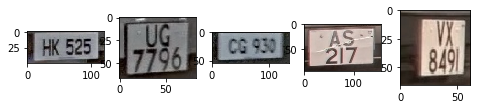

['HK525', 'UG7796', 'CG930', 'AS217', 'VX8491']

In [9]:
plot_imgs(imgs[:5])
img_gts[:5]

#### Dev Contrast

In [10]:
from models.car_locator import CarLocator
from models.plate_detector import PlateDetector
from models.segmentator import Segmentator
from models.char_recognizer import CharRecognizer

In [11]:
class Self():
    def __init__(self):
        pass
self = Self()

In [12]:
# self.car_locator = CarLocator(cfg['car_locator'])
# self.detector = PlateDetector(cfg['plate_detector'])
self.segmentator = Segmentator(cfg['segmentator'])
self.recognizer = CharRecognizer(cfg['char_recognizer'])

self.pad_x = cfg['lpr']['pad_x']
self.pad_y = cfg['lpr']['pad_y']

In [13]:
def max_contrast(img):
    ''' Increase img contrast to maximum '''
    Y = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)[:,:,0].astype('float')
    # compute min and max of Y
    MIN = np.min(Y)
    MAX = np.max(Y)
    alpha = 255. / (MAX-MIN)
    beta = -MIN * alpha
    return (img.astype('float')*alpha+beta).astype('uint8')

def clahe(img):
    #-----Converting image to LAB Color model----------------------------------- 
    lab= cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    #-----Splitting the LAB image to different channels-------------------------
    l, a, b = cv2.split(lab)
    #-----Applying CLAHE to L-channel-------------------------------------------
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    #-----Merge the CLAHE enhanced L-channel with the a and b channel-----------
    limg = cv2.merge((cl,a,b))
    #-----Converting image from LAB Color model to RGB model--------------------
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    return final

def identity(img):
    return img

In [14]:
def seg_rec(plates, func, mode='seg'):
    '''
    func:
        function names to apply to model input
    mode:
        'seg': apply to plate images before putting in segmentator
        'rec': apply to character images before OCR
        'segrec': apply to both models
    '''
    
    global img_gts 
    
    if 'seg' in mode:
        seg = func
    else:
        seg = lambda x: x
    
    if 'rec' in mode:
        rec = func
    else:
        rec = lambda x: x
    
    n_plates = len(plates)
    print('# plates input:', n_plates)
    
    # Batch predict segmentator
    bs = 8
    seg_out = []
    for i in range(0, n_plates, bs):
        i_end = min(i+bs, n_plates)
        seg_pred = self.segmentator.predict([seg(p) for p in plates[i:i_end]])
        seg_out.extend(seg_pred)
    print(f'# plates segmented: {sum(x is not None for x in seg_out)}/{len(seg_out)}')
    
    # Final result
    output = [None for _ in range(len(plates))]
    correct = 0
    
    # For each plate
    for i, preds in enumerate(seg_out):
        chars = []
        rp = rec(plates[i])
        # Predict plate num from CharRecognizer
        if preds is not None:
            for box in preds:
                x1,y1,x2,y2 = box[:4]
                chars.append(rp[y1:y2, x1:x2])
            plate_num, confidence = self.recognizer.predict(chars)
            status = 'success'
        # No chars in the plate
        else:
            plate_num = ''
            confidence = 0.0
            status = 'no characters segmented'
        
        # Ground truth
        gt = img_gts[i]
        if gt == plate_num:
            correct += 1
        output[i] = (f'gt: {gt}', plate_num, confidence)

    return output, correct

## Run from here

In [15]:
%%time
print('*** Plain vanilla ***')
_, correct = seg_rec(imgs, identity, '')
print(f'correct: {correct}/{n_imgs} ({(correct*100/n_imgs):.2f}%)')

*** Plain vanilla ***
# plates input: 769
# plates segmented: 767/769
correct: 625/769 (81.27%)
CPU times: user 41.8 s, sys: 1.17 s, total: 43 s
Wall time: 21.5 s


#### CLAHE

In [16]:
%%time
print('*** CLAHE contrast before segmentator only ***')
_, correct = seg_rec(imgs, clahe, 'seg')
print(f'correct: {correct}/{n_imgs} ({(correct*100/n_imgs):.2f}%)')

*** CLAHE contrast before segmentator only ***
# plates input: 769
# plates segmented: 767/769
correct: 631/769 (82.05%)
CPU times: user 42.5 s, sys: 383 ms, total: 42.9 s
Wall time: 20.6 s


In [17]:
%%time
print('*** CLAHE contrast before both segmentator & recognizer ***')
_, correct = seg_rec(imgs, clahe, 'segrec')
print(f'correct: {correct}/{n_imgs} ({(correct*100/n_imgs):.2f}%)')

*** CLAHE contrast before both segmentator & recognizer ***
# plates input: 769
# plates segmented: 767/769
correct: 643/769 (83.62%)
CPU times: user 45.2 s, sys: 471 ms, total: 45.7 s
Wall time: 20.9 s


In [18]:
%%time
print('*** CLAHE contrast before recognizer only ***')
_, correct = seg_rec(imgs, clahe, 'rec')
print(f'correct: {correct}/{n_imgs} ({(correct*100/n_imgs):.2f}%)')

*** CLAHE contrast before recognizer only ***
# plates input: 769
# plates segmented: 767/769
correct: 633/769 (82.31%)
CPU times: user 44.1 s, sys: 498 ms, total: 44.6 s
Wall time: 20.5 s


#### our own method

In [20]:
%%time
print('*** Our own max contrast before segmentator only ***')
_, correct = seg_rec(imgs, max_contrast, 'seg')
print(f'correct: {correct}/{n_imgs} ({(correct*100/n_imgs):.2f}%)')

*** Our own max contrast before segmentator only ***
# plates input: 769
# plates segmented: 768/769
correct: 618/769 (80.36%)
CPU times: user 41.1 s, sys: 316 ms, total: 41.4 s
Wall time: 20.3 s


In [21]:
%%time
print('*** Our own max contrast before both segmentator & recognizer ***')
_, correct = seg_rec(imgs, max_contrast, 'segrec')
print(f'correct: {correct}/{n_imgs} ({(correct*100/n_imgs):.2f}%)')

*** Our own max contrast before both segmentator & recognizer ***
# plates input: 769
# plates segmented: 768/769
correct: 609/769 (79.19%)
CPU times: user 41.8 s, sys: 404 ms, total: 42.2 s
Wall time: 20.5 s


In [22]:
%%time
print('*** Our own max contrast before recognizer only ***')
_, correct = seg_rec(imgs, max_contrast, 'rec')
print(f'correct: {correct}/{n_imgs} ({(correct*100/n_imgs):.2f}%)')

*** Our own max contrast before recognizer only ***
# plates input: 769
# plates segmented: 767/769
correct: 620/769 (80.62%)
CPU times: user 41.4 s, sys: 392 ms, total: 41.8 s
Wall time: 20.4 s


#### our own method + CLAHE

In [23]:
%%time
print('*** Our own + CLAHE contrast before segmentator only ***')
_, correct = seg_rec(imgs, lambda x: max_contrast(clahe(x)), 'seg')
print(f'correct: {correct}/{n_imgs} ({(correct*100/n_imgs):.2f}%)')

*** Our own + CLAHE contrast before segmentator only ***
# plates input: 769
# plates segmented: 767/769
correct: 600/769 (78.02%)
CPU times: user 42.1 s, sys: 388 ms, total: 42.5 s
Wall time: 20.3 s


In [24]:
%%time
print('*** Our own + CLAHE contrast before both segmentator & recognizer ***')
_, correct = seg_rec(imgs, lambda x: max_contrast(clahe(x)), 'segrec')
print(f'correct: {correct}/{n_imgs} ({(correct*100/n_imgs):.2f}%)')

*** Our own + CLAHE contrast before both segmentator & recognizer ***
# plates input: 769
# plates segmented: 767/769
correct: 566/769 (73.60%)
CPU times: user 46.4 s, sys: 374 ms, total: 46.8 s
Wall time: 21.3 s


In [25]:
%%time
print('*** Our own + CLAHE contrast before recognizer only ***')
_, correct = seg_rec(imgs, lambda x: max_contrast(clahe(x)), 'rec')
print(f'correct: {correct}/{n_imgs} ({(correct*100/n_imgs):.2f}%)')

*** Our own + CLAHE contrast before recognizer only ***
# plates input: 769
# plates segmented: 767/769
correct: 591/769 (76.85%)
CPU times: user 44.7 s, sys: 428 ms, total: 45.1 s
Wall time: 20.9 s
